## Исследование датасета с omniweb.gsfc.nasa.gov

Хотим найти следы 27-дневного цикла в разных показателях, которые предоставляет база данных. Ниже приведены индексы, измерения по которым обрабатывались. Также есть небольшая справка по некоторым из индексов (для себя).

* Year
* Day
* Hour
* Scalar B, nT - значение индукции в нано-Тесла
* Kp index
* R (Sunspot No.)
* Dst-index, nT
* ap_index, nT
* F10.7_index
* AE-index, nT                         
* AL-index, nT                         
* AU-index, nT                         
* pc-index                     
* Lyman_alpha  

> K-индекс — это отклонение магнитного поля Земли от нормы в течение трёхчасового интервала. Индекс был введён Юлиусом Бартельсом[de] в 1938 г. и представляет собой значения от 0 до 9 для каждого трёхчасового интервала (0-3, 3-6, 6-9 и т. д.) мирового времени.

> Kp-индекс — это планетарный индекс. Kp вычисляется как среднее значение К-индексов, определённых на 13 геомагнитных обсерваториях, расположенных между 44 и 60 градусами северной и южной геомагнитных широт. Его диапазон также от 0 до 9. 

>  The Earth's field ranges between approximately 25,000 and 65,000 nT

> The disturbance storm time (Dst, Kyoto Dst) index is a measure in the context of space weather. It gives information about the strength of the ring current around Earth caused by solar protons and electrons.[1]

> Ap-индекс отображает суточное значение геомагнитной активности, при этом, сутки с более высокими уровнем геомагнитной активности имеют более высокое значение Ap.

> The solar radio flux at 10.7 cm (2800 MHz) is an excellent indicator of solar activity. Often called the F10.7 index, it is one of the longest running records of solar activity. The F10.7 correlates well with the sunspot number as well as a number of UltraViolet (UV) and visible solar irradiance records.


In [2]:
# imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
# set random generator
generator = np.random.RandomState(42)

# settings of graphics
width = 17
height = 5
matplotlib.rcParams['figure.figsize'] = [width, height]
matplotlib.rcParams['lines.markersize'] = 0.5
matplotlib.rcParams['scatter.edgecolors'] = "black"

# autoregression generator
# p               memory parameter of autoregression, 0 <= p <= 1
# base_value      first value, from which the generation is initialized
# noise_maker     function of time which produces noise
# to_add          number of elements in result
def ar(p, base_value, noise_maker, to_add = 10000):
    new_vals = np.array(arr)
    new_vals = np.append(new_vals, [0] * to_add)
    pos = 1
    for i in range(to_add):
        noise = noise_maker(i)
        new_vals[pos + i] = p * new_vals[pos + i - 1] + noise
    return new_vals

# fourier transform
# returns array of amplitudes correcponding to different periods
# a        input array
# draw     to draw or not to draw the graphics
# def mfft(a, draw=False):
#     plt.rcParams['axes.grid'] = True
#     plt.tight_layout()
#     A = np.fft.rfft(a)
#     N = len(a)
#     if (draw):
#         plt.rcParams['axes.grid'] = True
#         fig, ax = plt.subplots(2, figsize=(6,4), dpi=150)
#         plt.tight_layout()
#         n = np.arange(len(a))
        
#         ax[0].plot(n, a, '.-')
#         ax[0].set_title('$a[n]$')
#         ax[1].set_xlim(0, 170)
#         ax[1].set_title('$A$')
#         ax[1].plot(n[0 : (N // 2 + 1)], np.abs(A), '-')
        
#     return np.abs(A / N)


# yet another fourier transform
# returns normalized amplitudes (scaled by the number of points)
# arr    input array
# draw   to draw or not to draw graphics of base data and amplitudes
# name   name of the feature
# x1     lower limit of periods to be displayed
# x2     upper limit of periods to be displayed
# y      upper limit of amplitudes to be displayed
def mfft2(arr, draw=False, name='a[n]', x1=0, x2=-1, y=0):
    if x2 == -1:
        x2 = len(arr) // 2 + 1
    plt.rcParams['axes.grid'] = True
    plt.tight_layout()
    A = np.fft.rfft((arr - np.mean(arr)) / len(arr))
    n = np.arange(len(arr))
    n1 = len(arr) / n[1:]
    if (draw):
        plt.rcParams['axes.grid'] = True
        fig, ax = plt.subplots(2, figsize=(6,4), dpi=150)
        plt.tight_layout()
        plt.subplots_adjust(hspace = 0.5)
        ax[0].plot(n, arr, '.-')
        ax[0].set_title(name)
        ax[0].set_ylim(-100, 100)
        ax[1].set_title('$A$')
        ax[1].set_xlim(x1, x2)
        ax[1].plot(n1[0 : (len(arr) // 2 + 1)], np.abs(A), '-')
        ax[1].set_xlabel('Период (в днях)')
        ax[1].set_ylabel('Амплитуда')
        if y != 0:
            ax[1].set_ylim(0, y)
        plt.show()
        
    return zip(n1[0 : (len(arr) // 2 + 1)], np.abs(A))

In [3]:
# load data
tmp_data = np.loadtxt('omni2_daily_eHiYe82FKM.lst').T
data = dict(zip(
['Year', 'Day', 'Hour', 'B', 'Kp', 'R', 'Dst', 'ap', 'F10.7', 'AE', 'AL', 'AU', 'pc', 'Lyman-alpha'],
tmp_data))

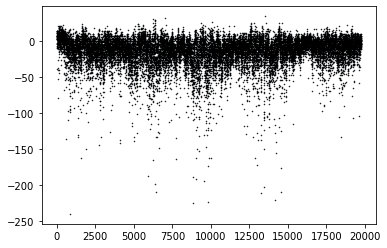

In [4]:
# draw Dst index
fix, ax = plt.subplots()
ax.scatter(np.arange(data['Dst'].size), data['Dst'])
plt.show()

In [5]:
N = data['Dst'].size
print(N)

19753


### Очистка данных

По графику видно, что выбросы в основном в отрицательной части графика. Посчитаем, какой процент точек лежит ниже прямой $y=-50$. Если значение невелико, то заменим все эти точки на $-50$.

In [6]:
n_under_min50 = len(list(filter(lambda x : x < -50, data['Dst'])))
print(n_under_min50 / len(data['Dst']))

0.04875208829038627


In [7]:
pure_dst = list(map(lambda x : max(x, -50), data['Dst']))

Попробуем применить преобразование Фурье к данному сету, по каждой координате.

In [8]:
# draws graphic of feature which is presented in table from omniweb and its mfft2 result
# name    name of the feature
# xlim    upper limit of periods
# ylim    upper limit of amplitudes
def draw_feature(name, xlim=100, ylim=0):
    if ylim == 0:
        mfft2(data[name], True, name, x1=0, x2=xlim)
    else:
        mfft2(data[name], True, name, x1=0, x2=xlim, y=ylim)

# draws some array and its mfft2
# name         name of the feature
# data_arr     input array for processing
# xlim         upper limit iot periods
# ylim         upper limit of periods
def draw_arr_feature(name, data_arr, xlim=100, ylim=0):
    if ylim == 0:
        mfft2(data_arr, True, name, x1=0, x2=xlim)
    else:
        mfft2(data_arr, True, name, x1=0, x2=xlim, y=ylim)

<Figure size 432x288 with 0 Axes>

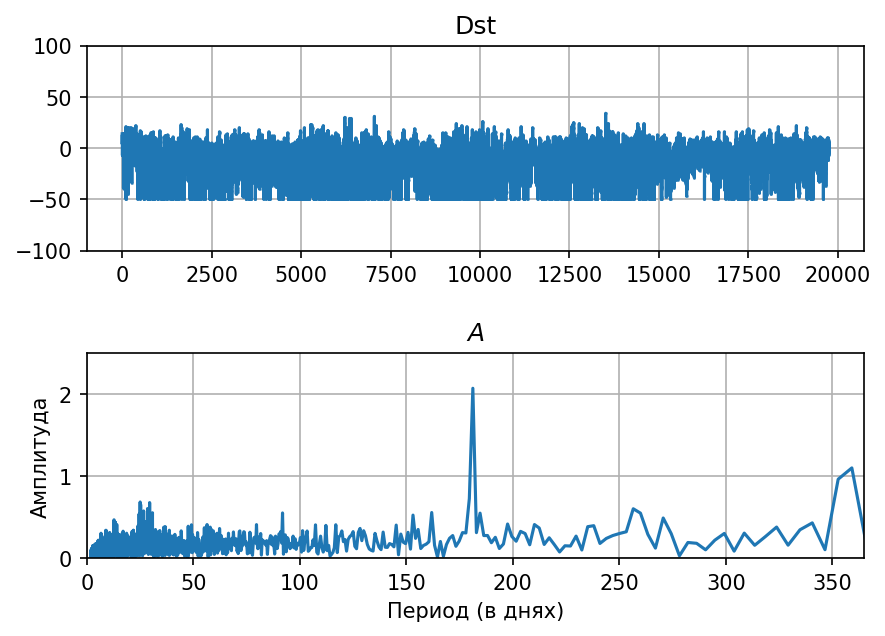

In [9]:
draw_arr_feature('Dst', pure_dst, xlim=365, ylim=2.5)

<Figure size 432x288 with 0 Axes>

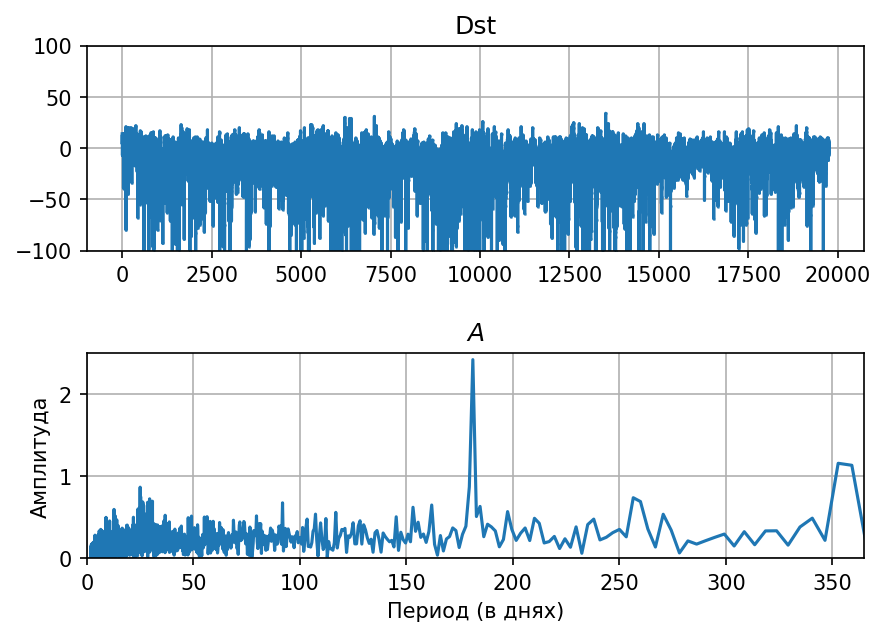

In [10]:
draw_feature('Dst', xlim=365, ylim=2.5)

<Figure size 432x288 with 0 Axes>

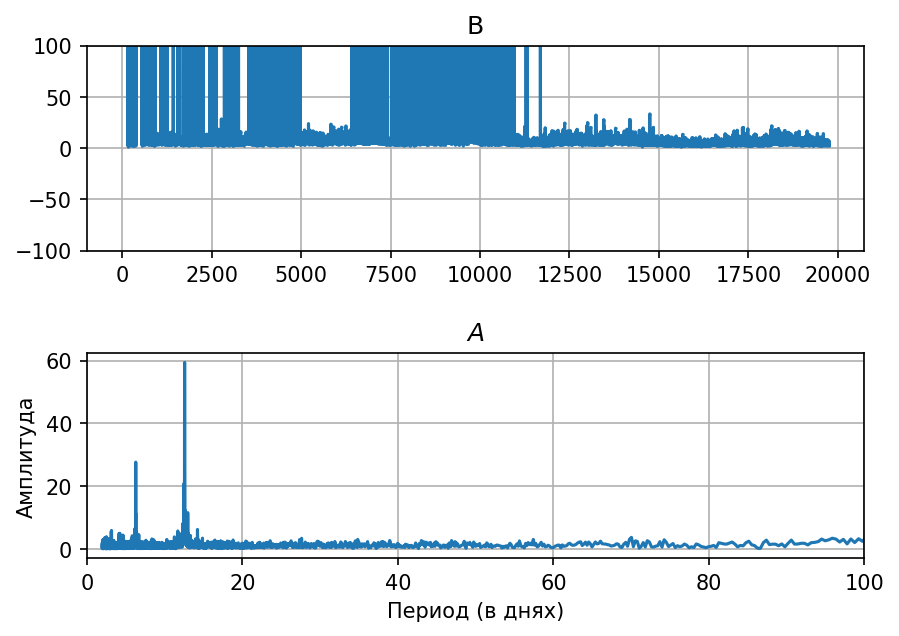

In [12]:
draw_feature('B')

<Figure size 432x288 with 0 Axes>

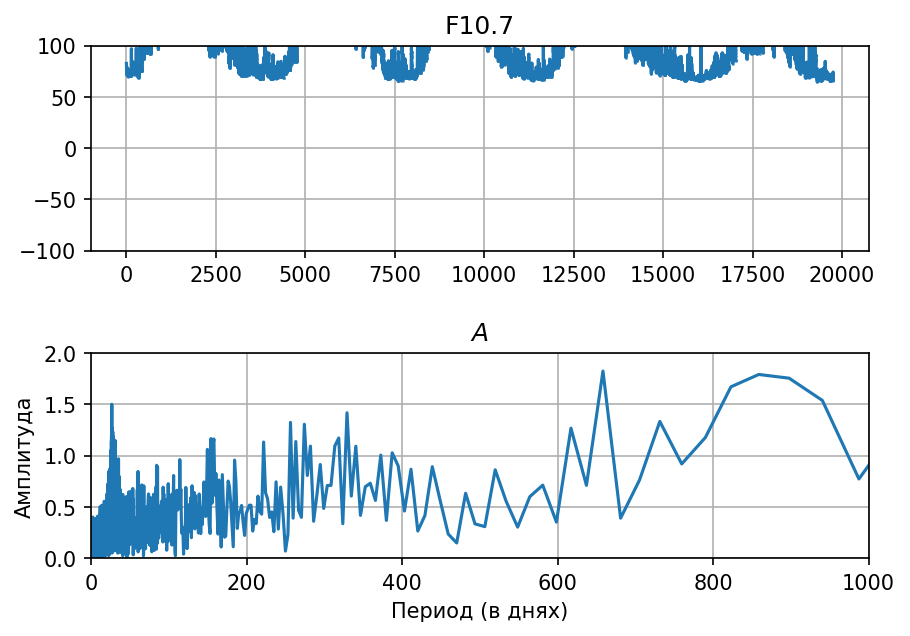

In [13]:
draw_feature('F10.7', xlim=1000, ylim=2)

# Моделируем AR-1

Возьмем окрестности equinox'ов в три месяца (окрестность будет регулироваться параметром delta), в ней наложим синусоидальный шум с периодом колебаний $T=27$ дней (период - параметр $T$). В остальных точках шум будет обычным белым. Возьмем, например, нормальное распределение $N(0,1)$. Попробуем процесс с $p=1$ и $p<1$. ($p$ - параметр "памяти" аворегрессии).

Добавлять шум будем с дня $spring-delta$ по $spring+delta$. Аналогично осенью.

In [14]:
# checks if point x is in d-neighbourhood of center
def in_delta(x, center, d):
    return np.abs(x - center) < d

### BULLSHIT Нормировка по общей энергии
Чтобы как-то устновить масштаб сгенерированных последовательностей, будем приводить энергию (сумму квадратов значений) искусственного колебания к энергии исходного , который есть во входных данных. Для этого считаем 

$$\mathcal{k} = \sqrt{\left(\dfrac{\sum_{j = 1}^n a_j^2}{\sum_{j=1}^n b_j^2}\right)}$$

и умножаем все элементы искусственной последовательности на этот коэффициент. Как будет видно далее, резко поменялся характер графика зависимости 27-; от параметра $p$.

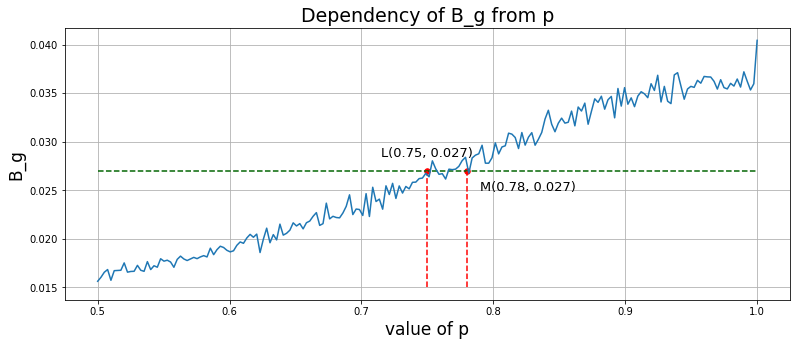


График после приведения энергии к общему значению стал таким:
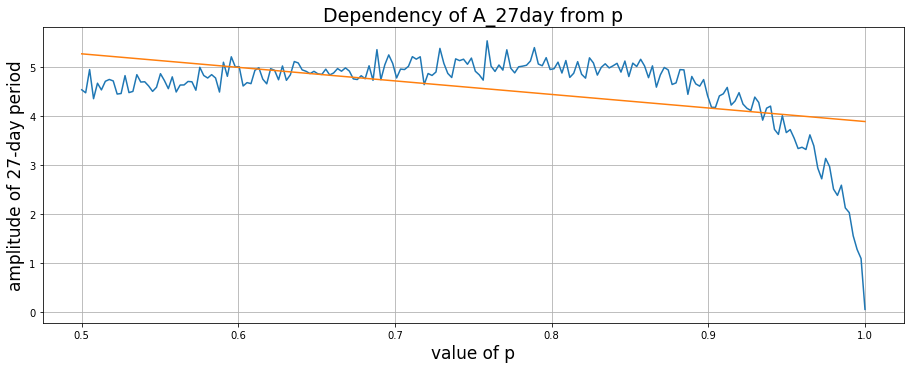
[27 days](#link1)

In [15]:
# here is the variation of <<ar>> method,
# but the noise added in delta-neighbourhood of specific points differs
# from the noise in the rest of the area
# delta      the radius of sinusoidal noise area
# T          sinusoidal noise will have this period and cyclic frequency 2 * pi / T
# p          memory parametr in autoregression
# A_sin      amplitude of sinusoidal noise
def imitate_Dst(delta=45, T=27, p=1, A_sin=1):
    spring = 79
    autumn = 266
    freq = 2 * np.pi / T
    noiser_basic = lambda : generator.normal(0, 1)
    noiser_sin = lambda i : A_sin * generator.normal(np.sin(freq * i), 1)
    start_value = -20
    arr = [start_value]
    for i in range(N):
        new_val = p * arr[-1]
        day = i % 365
        if in_delta(day, spring, delta) or in_delta(day, autumn, delta):
            # add noise_sin
            new_val += noiser_sin(day)
        else:
            # add noise_basic
            new_val += noiser_basic()
        arr.append(new_val)
    
    return list(map(lambda t : t * 1, arr))


<Figure size 432x288 with 0 Axes>

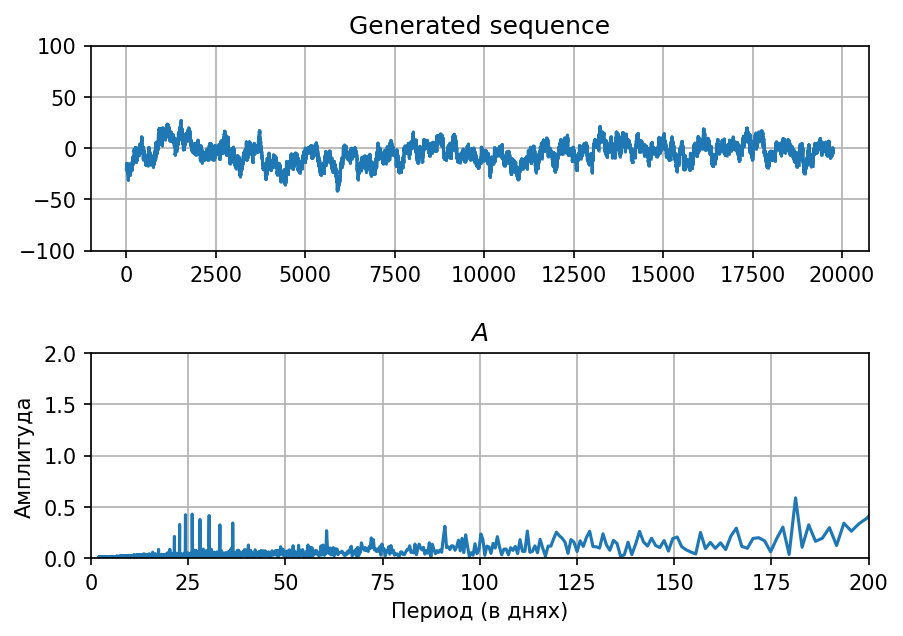

In [16]:
# default case
generated_data = imitate_Dst(p = 0.995, delta=33)
draw_arr_feature("Generated sequence", generated_data, xlim=200, ylim = 2)

<Figure size 432x288 with 0 Axes>

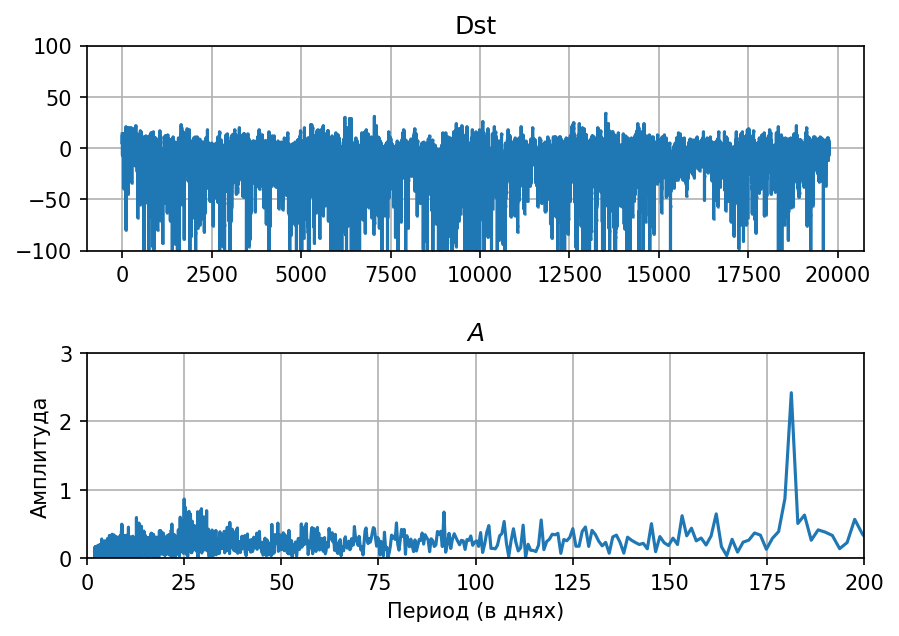

In [17]:
draw_feature("Dst", ylim=3, xlim=200)

<Figure size 432x288 with 0 Axes>

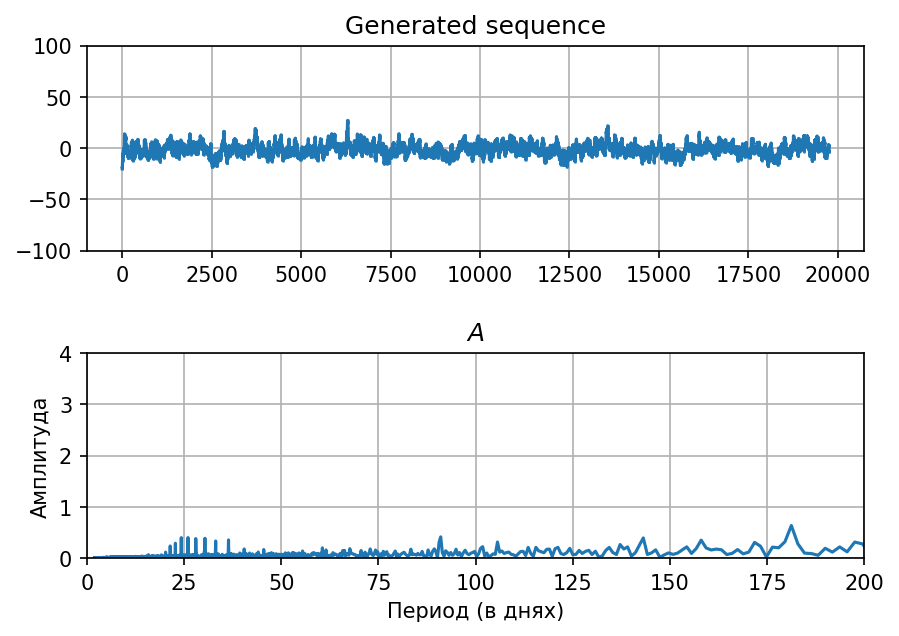

In [18]:
generated_data = imitate_Dst(delta=30, p=0.98, A_sin=1)
draw_arr_feature("Generated sequence", generated_data, xlim=200, ylim=4)

<Figure size 432x288 with 0 Axes>

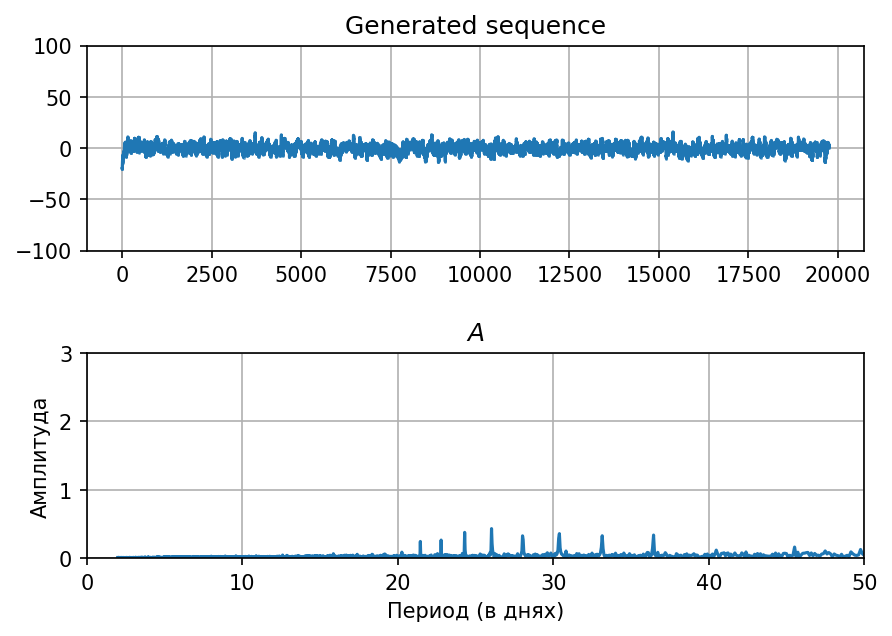

In [19]:
generated_data = imitate_Dst(delta=30, p=0.95, A_sin=1)
draw_arr_feature("Generated sequence", generated_data, xlim=50, ylim=3)

<Figure size 432x288 with 0 Axes>

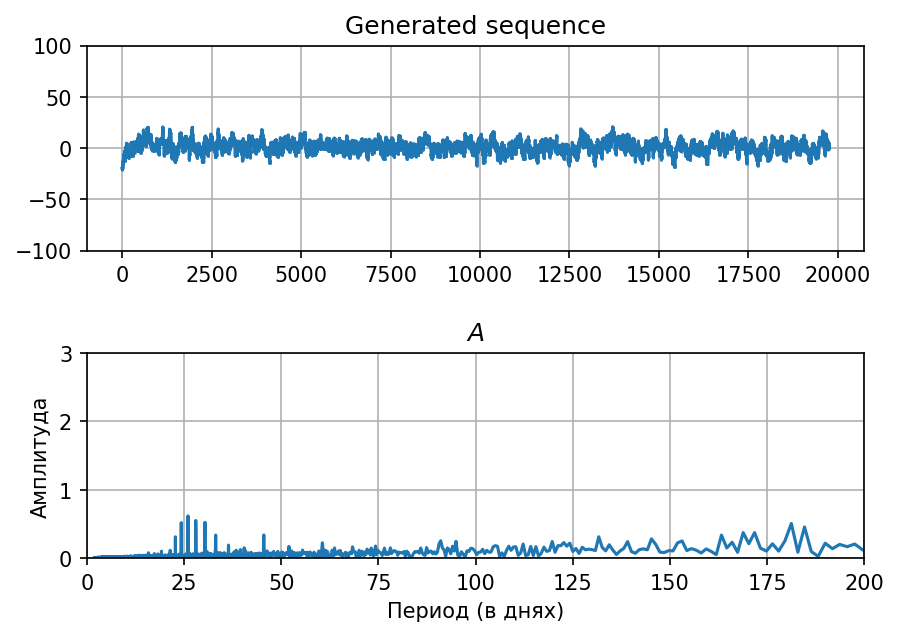

In [20]:
generated_data = imitate_Dst(p=0.98, A_sin=1)
draw_arr_feature("Generated sequence", generated_data, xlim=200, ylim=3)

## Зависимость полугодовой компоненты от параметров генерации

Исследуем, как меняется амплитуда на полугодовой компоненте в зависимости от параметров $p$ (память авторегрессии) и $delta$ (окрестность equinox'ов, в которой вводится синусоидальный шум).

Начнем с параметра $p$. Чтобы определить амплитуду полугодового сигнала, возьмем просто максимум на отрезке от 175 до 200.

In [21]:
from sklearn.metrics import mean_absolute_error

def get_amplitude_of_p(mp, left, right):
    generated_data = imitate_Dst(p=mp, A_sin=1)
    generated_data = list(map(lambda x : x, generated_data))
    fft_res = list(mfft2(generated_data, False, ""))
    filtered = filter(lambda x : left <= x[0] <= right, fft_res)
    return(max(map(lambda x : x[1], filtered)))

def get_semiannual_amp(mp):
    return get_amplitude_of_p(mp, 175, 190)

def get_27day_amp(mp):
    return get_amplitude_of_p(mp, 24, 30)

def draw_semiannual_amplitude(p_from=0.5, p_to=1, n=100):
    plt.figure(figsize=(13, 5))
    plt.xlabel("value of p", fontsize=17)
    plt.ylabel("amplitude of semi-annual period", fontsize=17)
    ps = np.linspace(p_from, p_to, n)
    res = list(map(lambda px : get_semiannual_amp(px), ps))
    plt.title("Dependency of A_semiannual from p", fontsize=19)
    plt.plot(ps, res)
    
def draw_27day_amplitude(p_from=0.5, p_to=1, n=100):
    plt.figure(figsize=(13, 5))
    plt.xlabel("value of p", fontsize=17)
    plt.ylabel("amplitude of 27-day period", fontsize=17)
    ps = np.linspace(p_from, p_to, n)
    res = list(map(lambda px : get_27day_amp(px), ps))
    approx_polynom = np.polyfit(ps, res, 1)
    approx = np.polyval(approx_polynom, ps)
    
    plt.title("Dependency of A_27day from p", fontsize=19)
    plt.plot(ps, res)
    plt.plot(ps, approx)
    print("polynomial : ", approx_polynom)
    
    mape = mean_absolute_error(res, approx) / sum(list(map(abs, res)))
    print("mean average error : ", mape)
    
def draw_amplitude_relation(p_from=0.5, p_to=1, n=100):
    plt.figure(figsize=(13, 5))
    plt.xlabel("value of p", fontsize=17)
    plt.ylabel("relation A_semi/A_27 ", fontsize=17)
    ps = np.linspace(p_from, p_to, n)
    res = list(map(lambda x : get_semiannual_amp(x) / max(0.01, get_27day_amp(x)), ps))
    plt.title("Dependency of amplitude relationship from p", fontsize=19)
    plt.plot(ps, res)

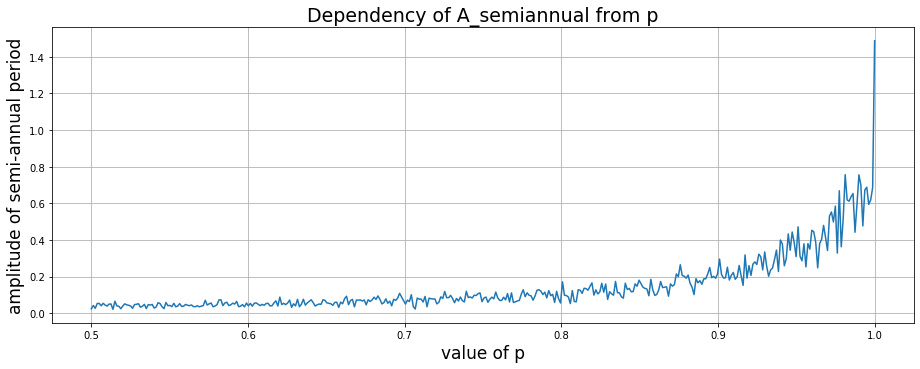

In [22]:
#
draw_semiannual_amplitude(0.5, 1, 400)

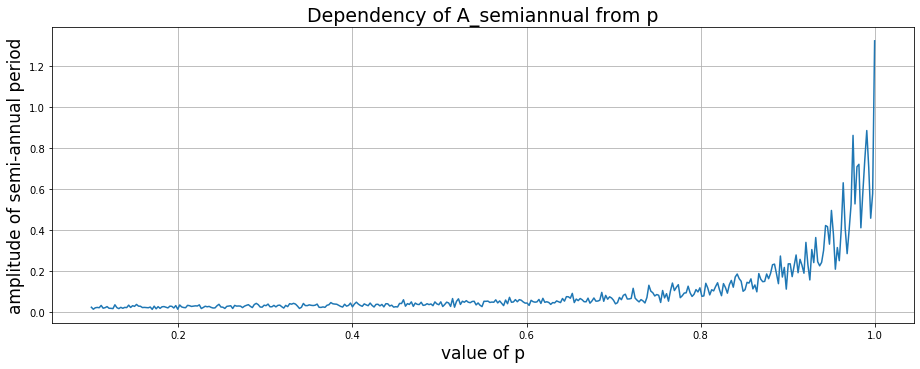

In [23]:
draw_semiannual_amplitude(0.1, 1, 400)

## <a id='link1'>Клетка с вычислениями -- 27 days</a>

polynomial :  [ 0.76474723 -0.13049068]
mean average error :  0.0001843279553199334


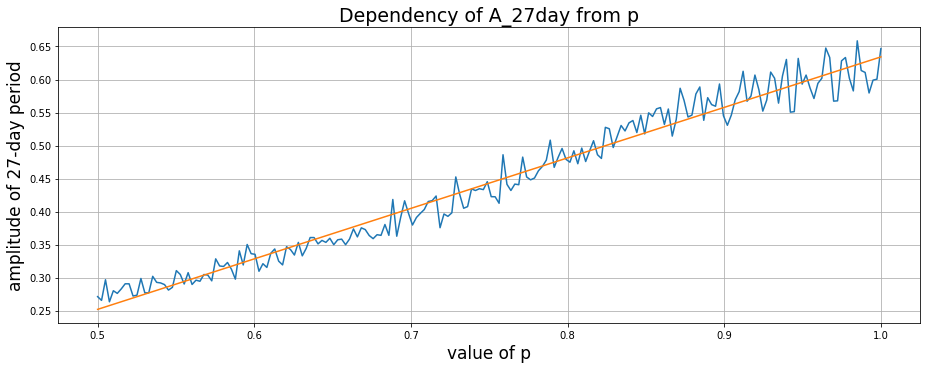

In [24]:
# p in [0.5, 1], Number of points = 200

draw_27day_amplitude(0.5, 1, 200)

polynomial :  [0.54184331 0.03815489]
mean average error :  0.0001757236990920043


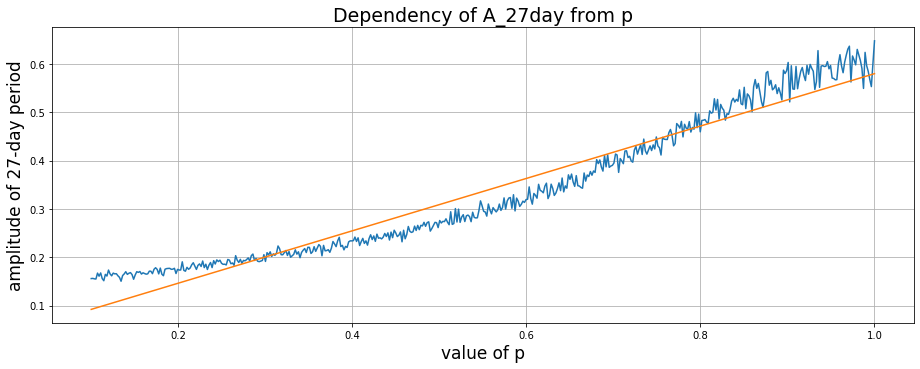

In [25]:
# p in [0.1, 1], Number of points = 500
draw_27day_amplitude(0.1, 1, 500)

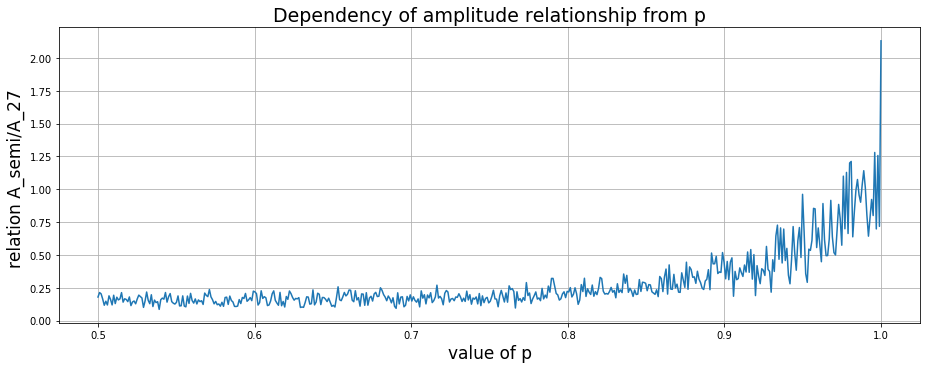

In [26]:
# полугодовая амплитуда к 27-дневной при значениях p от 0.5 до 1
draw_amplitude_relation(0.5, 1, 500)

Перейдем к зависимости от выбора окрестности. Будем менять ее от 1 до 180 дней.

In [27]:
def get_amplitude_of_delta(mdelta):
    generated_data = imitate_Dst(p=0.95, A_sin=10, delta=mdelta)
    fft_res = list(mfft2(generated_data, False, ""))
    filtered = filter(lambda x : 175 <= x[0] <= 200, fft_res)
    return(max(map(lambda x : x[1], filtered)))

def draw_amplitude_from_delta(d_from=1, d_to=180):
    plt.xlabel('delta')
    plt.ylabel('amplitude of semi-annual period')
    plt.title('Dependency of A_semiannual from delta')
    deltas = np.arange(d_from, d_to)
    res = list(map(get_amplitude_of_delta, deltas))
    plt.plot(deltas, res)

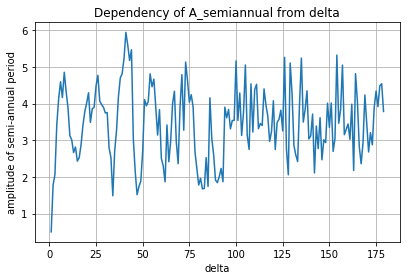

In [28]:
draw_amplitude_from_delta()

Как мы видим, от окна, в котором вводится синусоидальный шум, ничего не зависит. График не дает никакой информации. Зависимость полугодовой и 27-дневной компоненты (ее амплитуды) от параметра $p$ видна ярче. В частности, 27-дневная компонента линейно зависит от $p$, если судить по графику.  На основании отношения $A_{semi} / A_{27}$ можно установить параметр $p$ для реальных данных, так как зависимость (на модельных данных) получается монотонной.

In [29]:
!pip install --user sklearn

In [30]:
# the same code but the data is real
from sklearn.preprocessing import normalize

def get_amplitude_of_p_real():
    dst = data['Dst']
    print(max(dst), min(dst))
    #fft_res = list(mfft2(normalize([dst]).reshape(1,-1)[0], False, ""))
    fft_res = list(mfft2(dst, False, ""))
    filtered = filter(lambda x : 175 <= x[0] <= 190, fft_res)
    lst = list(map(lambda x : x[1], filtered))
    return(max(lst))

def get_amplitude_of_p27_real():
    dst = data['Dst']
    fft_res = list(mfft2(dst, False, ""))
    filtered = filter(lambda x : 24 <= x[0] <= 30, fft_res)
    return(max(map(lambda x : x[1], filtered)))

def get_relation():
    semiann = get_amplitude_of_p_real()
    day27 = get_amplitude_of_p27_real()
    print("semiannual amplitude =", semiann)
    print("27-day amplitude =", day27)
    return semiann / day27


In [31]:
get_relation()

34.0 -240.0
semiannual amplitude = 2.420463660162552
27-day amplitude = 0.8646156861129406


2.79946766990112

<Figure size 432x288 with 0 Axes>

In [32]:
get_relation()

34.0 -240.0
semiannual amplitude = 2.420463660162552
27-day amplitude = 0.8646156861129406


2.79946766990112

<Figure size 432x288 with 0 Axes>

In [33]:
get_relation()

34.0 -240.0
semiannual amplitude = 2.420463660162552
27-day amplitude = 0.8646156861129406


2.79946766990112

<Figure size 432x288 with 0 Axes>

### Нормировка

Делим очищенный массив реальных точек на 25, массив сгенерированный --- на 20.

In [34]:
# with custom normalization
def get_amplitude_of_p_real_norm():
    dst = pure_dst.copy()
    dst = list(map(lambda x : x / 25, dst))
    print(max(dst), min(dst))
    fft_res = list(mfft2(dst, False, ""))
    filtered = filter(lambda x : 175 <= x[0] <= 190, fft_res)
    lst = list(map(lambda x : x[1], filtered))
    return(max(lst))

def get_amplitude_of_p27_real_norm():
    dst = pure_dst.copy()
    dst = list(map(lambda x : x / 25, dst))
    print(max(dst), min(dst))
    fft_res = list(mfft2(dst, True, ""))
    filtered = filter(lambda x : 24 <= x[0] <= 30, fft_res)
    return(max(map(lambda x : x[1], filtered)))

def get_relation_norm():
    semiann = get_amplitude_of_p_real()
    day27 = get_amplitude_of_p27_real()
    print("semiannual amplitude =", semiann)
    print("27-day amplitude =", day27)
    return semiann / day27


1.36 -2.0


<Figure size 432x288 with 0 Axes>

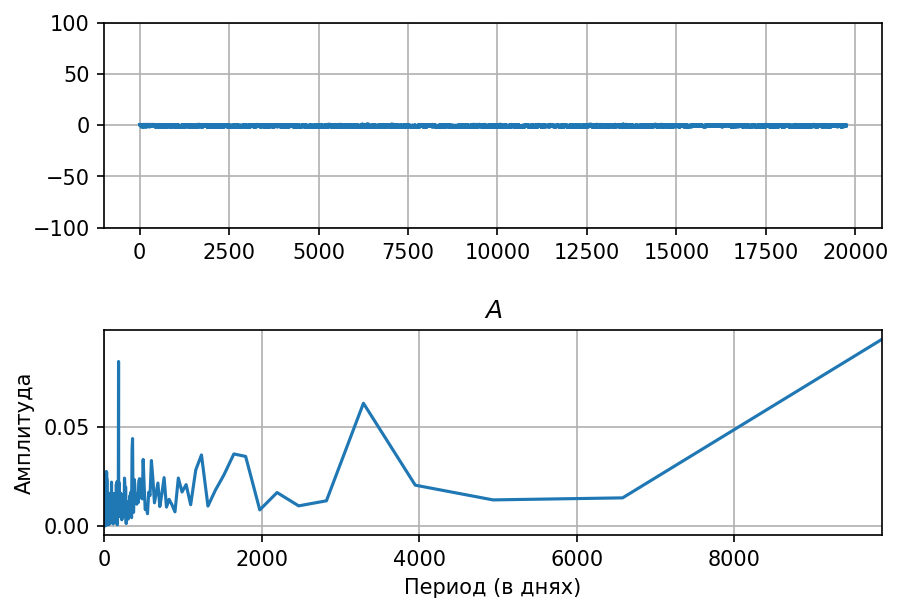

0.02735906967493951

In [35]:
get_amplitude_of_p27_real_norm()

In [36]:
def get_coord(p_from, p_to, n, normalization=20):
    ps = np.linspace(p_from, p_to, n)
    res = list(map(lambda px : get_27day_amp(px, normalization), ps))
    return res

coord = get_coord(0.5, 1, 200)

TypeError: get_27day_amp() takes 1 positional argument but 2 were given

In [ ]:
def draw_27_amplitude_with_lines(p_from=0.5, p_to=1, n=100, normalization=1):
    ans = 0.027
    plt.figure(figsize=(13, 5))
    plt.xlabel("value of p", fontsize=17)
    plt.ylabel("B_g", fontsize=17)
    ps = np.linspace(p_from, p_to, n)
    res = coord
    #res = list(map(lambda px : get_27day_amp(px, normalization), ps))
    plt.hlines(ans, p_from, p_to, color='darkgreen', linestyle="--")
    plt.scatter(0.75, ans, color='red', marker='o', s=30)
    plt.annotate('L(0.75, 0.027)', (0.715, ans+0.0015), fontsize=13)
    plt.scatter(0.78, ans, color='red', marker='o', s=30)
    plt.annotate('M(0.78, 0.027)', (0.79, ans-0.002), fontsize=13)
    plt.vlines(0.75, 0.015, ans, color='red', linestyle="--")
    plt.vlines(0.78, 0.015, ans, color='red', linestyle="--")
    plt.title("Dependency of B_g from p", fontsize=19)
    plt.plot(ps, res)

In [ ]:
draw_27_amplitude_with_lines(0.5, 1, 200, normalization=20)